<a href="https://colab.research.google.com/github/nxxk23/AI-Engineer/blob/main/Price/prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
data =pd.read_csv('/content/drive/MyDrive/AIEngineer/fraud/opd_discharge_August_2024.csv')
data.head()

,id,seq,created_at,updated_at,deleted_at,service_setting,illnes_type,policy_type,cid,cid_type,...,invoice_no,remark,created_submit_by,updated_submit_by,created_submit_at,updated_submit_at,other_insurer,is_check_claim_balance,is_reimbursement,epayment_id
0,5ac01d28-649e-45f1-bd6c-28bef03177fd,1723362821876838256,2024-08-11 14:53:41.876 +0700,2024-09-01 01:03:48.499 +0700,NaN,OPD,ILL,CS,3510600017435,NATIONAL_ID,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,N,4f632ac4-ca8e-4f0e-8c8d-7ed56a984f37
1,a58ad61f-5b33-4429-986a-c382d5f23a50,1725096090864466167,2024-08-31 16:21:30.864 +0700,2024-09-01 01:03:36.471 +0700,NaN,OPD,ACC,IB,3101202037015,NATIONAL_ID,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,N,1f43a222-41bf-45b2-8ed6-975488de9f2f
2,6fd19ff2-7795-48f4-8d88-489480e2bfbe,1725002199712584475,2024-08-30 14:16:39.712 +0700,2024-09-01 01:02:13.640 +0700,NaN,OPD,ILL,CS,1100700853593,NATIONAL_ID,...,3167230668,NaN,299cdc89-c705-40fa-b6a6-97f0a8f4e7f4,NaN,2024-09-17 13:19:53.204 +0700,NaN,False,NaN,N,8eee2860-bbf8-4f67-b22e-623b0cfe5dab
3,70e37d78-2db3-40f0-a139-e46d353466b0,1724063329282619820,2024-08-19 17:28:49.282 +0700,2024-09-01 01:02:32.927 +0700,NaN,OPD,ILL,CS,1102001744428,NATIONAL_ID,...,O13-6708-30159,NaN,NaN,NaN,NaN,NaN,False,NaN,N,10469d3c-a44c-42ab-ad39-e28f17a290d8
4,ecd8eec0-86b0-4ed1-a75f-6e724079fa73,1725001867113543084,2024-08-30 14:11:07.113 +0700,2024-09-01 01:02:13.640 +0700,NaN,OPD,ILL,CS,1103701107367,NATIONAL_ID,...,3167230670,NaN,299cdc89-c705-40fa-b6a6-97f0a8f4e7f4,NaN,2024-09-17 13:20:32.262 +0700,NaN,False,NaN,N,8eee2860-bbf8-4f67-b22e-623b0cfe5dab


In [13]:
# data[data['order_item']!='[]']['hospital_code'].value_counts()

In [14]:
df = data[(data['order_item']!='[]') & (data['hospital_code']==11787)][['hospital_code','patient','vital_sign','order_item','billing','total_bill_amount','diagnosis']]

In [17]:
import json
def extract_primary_icd10(diagnosis_str):
    try:
        diagnoses = json.loads(diagnosis_str)
        if isinstance(diagnoses, list):
            for d in diagnoses:
                if isinstance(d, dict) and d.get("dx_type") == "PP":
                    return d.get("icd10")
    except (json.JSONDecodeError, TypeError):
        pass
    return None

df['icd10'] = df['diagnosis'].apply(extract_primary_icd10)

In [28]:
import pandas as pd
import json
test = df[df['icd10']=='J069']
# Flatten the JSON in 'billing' column
df_billing = pd.json_normalize(test['billing'].apply(json.loads).explode())

In [34]:
import pandas as pd
import numpy as np

# Ensure billing_net_amount is numeric
df_billing['billing_net_amount'] = pd.to_numeric(df_billing['billing_net_amount'], errors='coerce')

# Drop rows with invalid numeric values (if any)
df_billing = df_billing.dropna(subset=['billing_net_amount'])

# Aggregate by local_billing_name
billing_summary = df_billing.groupby('local_billing_name').agg(
    mean_cost=('billing_net_amount', 'mean'),
    median_cost=('billing_net_amount', 'median'),
    mode_cost=('billing_net_amount', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    count=('billing_net_amount', 'count')
).reset_index()

billing_summary

,local_billing_name,mean_cost,median_cost,mode_cost,count
0,First Outpatient care before admission ค่าแพท...,758.560000,800.0,800.0,125
1,General Medical Equipment ค่าอุปกรณ์นอกห้องผ่...,680.000000,680.0,680.0,2
2,Laboratory Investigation and Pathology ค่าตรว...,1136.578947,1180.0,1180.0,19
3,Medical Supplies 1 เวชภัณฑ์1,77.566667,25.0,25.0,30
4,Nursing and Midwifery Charge ค่าบริการพยาบาล,185.000000,185.0,185.0,121
5,Other Medical Service Charge ค่าบริการทางการแพทย์,181.991870,185.0,185.0,123
6,Outpatient Medication ค่ายาผู้ป่วยนอก,864.833333,755.0,830.0,126
7,Packaged Medical Charges ค่าบริการชุดเหมาจ่าย,147.142857,100.0,100.0,7
8,Physical Therapy ค่ากายภาพบำบัด,990.000000,990.0,990.0,1


In [ ]:
import ast

df = pd.DataFrame(data)

# Preprocessing patient column
def extract_patient_info(patient_str):
    patient_data = ast.literal_eval(patient_str)
    return pd.Series({
        "dob": patient_data.get("dob"),
        "gender": patient_data.get("gender")
    })

patient_info = df["patient"].apply(extract_patient_info)
df = pd.concat([df, patient_info], axis=1)

def extract_vital_signs(vital_sign_str):
    vital_data = ast.literal_eval(vital_sign_str)[0]  # Convert string to list of dicts and take the first dict

    def clean_float(value):
        try:
            # Strip whitespace and convert to float
            return float(str(value).strip()) if str(value).strip() != '' else 0.0
        except (ValueError, TypeError):
            # Return 0.0 for invalid or missing values
            return 0.0

    return pd.Series({
        "heart_rate": clean_float(vital_data.get("heart_rate", 0)),
        "pain_score": clean_float(vital_data.get("pain_score", 0)),
        "systolic_bp": clean_float(vital_data.get("systolic_bp", 0)),
        "diastolic_bp": clean_float(vital_data.get("diastolic_bp", 0)),
        "temperature": clean_float(vital_data.get("temperature", 0)),
        "respiratory_rate": clean_float(vital_data.get("respiratory_rate", 0)),
        "oxygen_saturation": clean_float(vital_data.get("oxygen_saturation", 0)),
        "vital_sign_entry_datetime": pd.to_datetime(vital_data.get("vital_sign_entry_datetime"), errors='coerce')
    })

vital_signs = df["vital_sign"].apply(extract_vital_signs)
df = pd.concat([df, vital_signs], axis=1)

In [ ]:
from datetime import datetime

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, "%Y-%m-%d")
    today = datetime.today()
    return today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))

df["age"] = df["dob"].apply(calculate_age)

In [ ]:
mapping = {
    "ILL": 1,
    "ACC": 2,
    "ER": 3,
    "FU": 4,
    "DEN": 5,
    "HD": 6
}
gender = {
    "F": 0,
    "M": 1
}
df["illnes_type"] = df["illnes_type"].map(mapping)
df["gender"] = df["gender"].map(gender)
df.rename(columns={"illnes_type": "illness_type"}, inplace=True)

In [ ]:
df.columns

Index(['cid', 'patient', 'illness_type', 'chief_complaint', 'vital_sign',
       'billing', 'diagnosis', 'total_bill_amount', 'hn', 'dob', 'gender',
       'heart_rate', 'pain_score', 'systolic_bp', 'diastolic_bp',
       'temperature', 'respiratory_rate', 'oxygen_saturation',
       'vital_sign_entry_datetime', 'age'],
      dtype='object')

In [ ]:
df = df.drop(columns=['patient', 'vital_sign', 'dob', 'billing'])

## v2

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14887 entries, 0 to 14886
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cid                        14887 non-null  object 
 1   illness_type               14887 non-null  int64  
 2   chief_complaint            14887 non-null  object 
 3   diagnosis                  14887 non-null  object 
 4   total_bill_amount          14887 non-null  float64
 5   gender                     14887 non-null  int64  
 6   heart_rate                 14887 non-null  float64
 7   pain_score                 14201 non-null  float64
 8   systolic_bp                14887 non-null  float64
 9   diastolic_bp               14887 non-null  float64
 10  temperature                14887 non-null  float64
 11  respiratory_rate           14887 non-null  float64
 12  oxygen_saturation          14887 non-null  float64
 13  vital_sign_entry_datetime  14887 non-null  obj

In [ ]:
data['diagnosis'][0]

'[{"icd10": "S711", "dx_name": "Open wound of thigh", "dx_type": "PP"}, {"icd10": "W220", "dx_name": "Striking against or struck by other object(s)\xa0: at home", "dx_type": "EC"}]'

In [ ]:
import pandas as pd
import json

df = data.copy()
import ast
# Step 1: Convert diagnosis column to Python objects
df['icd10'] = df['diagnosis'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 2: Function to process and split rows for multiple dx_types
def split_diagnoses(row):
    diagnoses = row['icd10']
    dx_dict = {}
    rows = []

    # Group diagnoses by dx_type
    for diag in diagnoses:
        dx_type = diag['dx_type']
        if dx_type not in dx_dict:
            dx_dict[dx_type] = []
        dx_dict[dx_type].append(diag['icd10'])

    # Create rows for each combination of dx_type
    from itertools import product
    keys, values = zip(*dx_dict.items())
    for combination in product(*values):  # Cartesian product of all dx_type combinations
        new_row = row.copy()
        for i, key in enumerate(keys):
            new_row[key] = combination[i]
        rows.append(new_row)
    return rows

# Step 3: Apply the splitting function
processed_rows = []
for _, row in df.iterrows():
    processed_rows.extend(split_diagnoses(row))

final_df = pd.DataFrame(processed_rows)

In [ ]:
final_df.drop(columns=['diagnosis','cid', 'vital_sign_entry_datetime'], inplace=True)
final_df.columns

Index(['illness_type', 'chief_complaint', 'total_bill_amount', 'gender',
       'heart_rate', 'pain_score', 'systolic_bp', 'diastolic_bp',
       'temperature', 'respiratory_rate', 'oxygen_saturation', 'age', 'icd10',
       'PP', 'EC', 'OT', 'CM', 'CP'],
      dtype='object')

In [ ]:
# import pandas as pd

# def extract_pp_dx_name(row):
#     icd10_list = row['icd10']
#     if isinstance(icd10_list, list):
#         for item in icd10_list:
#             if item.get('dx_type') == 'PP':
#                 return item.get('dx_name')
#     return row['dx']

# final_df['dx'] = final_df.apply(extract_pp_dx_name, axis=1)

In [ ]:
final_df['group'] = final_df['PP'].str[0]
final_df['group'] = final_df['group'].replace('k', 'K')

In [ ]:
# Define a mapping of first letters to disease groups
icd10_groups = {
    '0': 'Temporary diagnosis',
    'A': 'Infectious and parasitic diseases',
    'B': 'Infectious and parasitic diseases',
    'C': 'Neoplasms',
    'D': 'Diseases of blood and blood-forming organs',
    'E': 'Endocrine, nutritional, and metabolic diseases',
    'F': 'Mental and behavioral disorders',
    'G': 'Diseases of the nervous system',
    'H': 'Diseases of the eye, ear, and mastoid process',
    'I': 'Diseases of the circulatory system',
    'J': 'Diseases of the respiratory system',
    'K': 'Diseases of the digestive system',
    'L': 'Diseases of the skin and subcutaneous tissue',
    'M': 'Diseases of the musculoskeletal system',
    'N': 'Diseases of the genitourinary system',
    'O': 'Pregnancy, childbirth, and the puerperium',
    'P': 'Certain conditions originating in the perinatal period',
    'Q': 'Congenital malformations',
    'R': 'Symptoms and abnormal findings',
    'S': 'Injuries and poisoning',
    'T': 'Injuries and poisoning',
    'V': 'External causes of morbidity',
    'W': 'External causes of morbidity',
    'X': 'External causes of morbidity',
    'Y': 'External causes of morbidity',
    'Z': 'Health status and health services'
}

# Extract the first letter of the 'PP' column and map it to the disease group
final_df['disease_group'] = final_df['PP'].str[0].map(icd10_groups)

In [ ]:
unique_groups = final_df['group'].dropna().unique()
group_to_num = {group: idx + 1 for idx, group in enumerate(sorted(unique_groups))}
final_df['dx'] = final_df['group'].map(group_to_num)

In [ ]:
final_df.columns

Index(['illness_type', 'chief_complaint', 'total_bill_amount', 'gender',
       'heart_rate', 'pain_score', 'systolic_bp', 'diastolic_bp',
       'temperature', 'respiratory_rate', 'oxygen_saturation', 'age', 'icd10',
       'PP', 'EC', 'OT', 'CM', 'CP', 'dx', 'group', 'disease_group'],
      dtype='object')

In [ ]:
X = final_df[['illness_type','gender','age','heart_rate','systolic_bp','diastolic_bp',
              'temperature','respiratory_rate','oxygen_saturation','dx']]
y = final_df['total_bill_amount'].round(2)

In [ ]:
X

,illness_type,gender,age,heart_rate,systolic_bp,diastolic_bp,temperature,respiratory_rate,oxygen_saturation,dx
0,2,1,58,76.0,156.0,82.0,36.6,20.0,99.0,18
1,1,0,35,80.0,119.0,90.0,36.9,20.0,99.0,11
2,1,1,36,82.0,114.0,70.0,36.7,20.0,96.0,11
3,1,0,30,80.0,116.0,68.0,36.6,20.0,100.0,15
4,1,0,38,92.0,133.0,53.0,36.6,20.0,98.0,11
...,...,...,...,...,...,...,...,...,...,...
14882,2,1,38,102.0,198.0,97.0,36.6,20.0,0.0,18
14883,2,0,35,97.0,128.0,95.0,36.5,20.0,100.0,18
14884,1,0,51,88.0,132.0,76.0,36.2,20.0,90.0,17
14885,1,1,34,72.0,100.0,60.0,39.2,98.0,20.0,11


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15180 entries, 0 to 14886
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   illness_type       15180 non-null  int64  
 1   gender             15180 non-null  int64  
 2   age                15180 non-null  int64  
 3   heart_rate         15180 non-null  float64
 4   systolic_bp        15180 non-null  float64
 5   diastolic_bp       15180 non-null  float64
 6   temperature        15180 non-null  float64
 7   respiratory_rate   15180 non-null  float64
 8   oxygen_saturation  15180 non-null  float64
 9   dx                 15180 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 1.8 MB


In [ ]:
correlations = X.corrwith(y)
correlations.sort_values(ascending=False)

,0
illness_type,0.162640
dx,0.096898
systolic_bp,0.068474
diastolic_bp,0.049485
oxygen_saturation,0.039498
age,0.035399
respiratory_rate,0.020976
gender,0.015750
heart_rate,0.011307
temperature,-0.033586


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
2,age,0.194389
3,heart_rate,0.178215
4,systolic_bp,0.158574
6,temperature,0.147900
5,diastolic_bp,0.095476
0,illness_type,0.090698
8,oxygen_saturation,0.067619
9,dx,0.037559
1,gender,0.015581
7,respiratory_rate,0.013988


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X, y)

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

coefficients

,Feature,Coefficient
0,illness_type,1144.620206
1,gender,41.905625
6,temperature,-25.110214
9,dx,21.409471
7,respiratory_rate,13.443999
4,systolic_bp,10.660830
5,diastolic_bp,-7.997006
8,oxygen_saturation,4.129063
3,heart_rate,2.025370
2,age,1.725247


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 84924266.7637619
R2 Score: 0.022212507230017775


In [ ]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print("Linear Regression R2 Score:", r2_score(y_test, y_pred_lr))

Linear Regression R2 Score: 0.011839835983376346


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print("Gradient Boosting R2 Score:", r2_score(y_test, y_pred_gb))


Gradient Boosting R2 Score: 0.021569507158720413


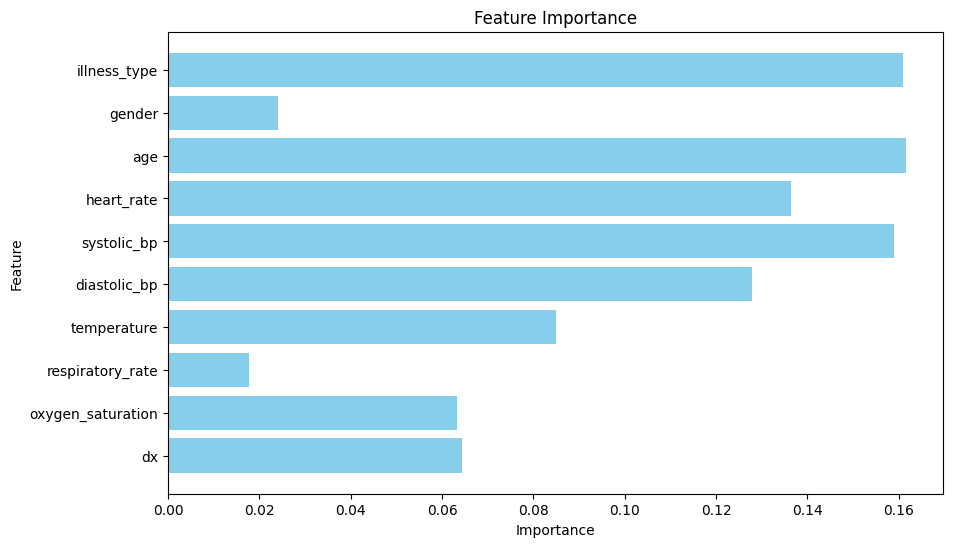

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_model.feature_importances_
features = X.columns

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()
